In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.beam_utils import gaussian_beam
import tdwg_lib.ftutils_torch as ftutils

## Main

In [3]:
# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode

# Transverse (x) axis
LX = 500  # Width of simulation area in μm
NX = 2**9  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 10.  # Propagation step size in μm
LZ = 10000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

In [4]:
# Set up the split-step solver to integrate the paraxial wave equation with the beam propagation method
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

## Define refractive index distribution and inputs

Text(0.5, 1.0, 'Refractive index distribution of Y-splitter')

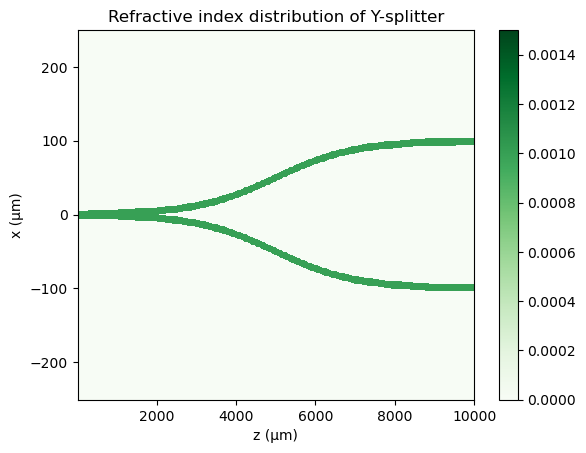

In [5]:
# Y-splitter geometry parameters
DEFLECTION = 100  # Maximum deflection of Y-splitter branches in μm (transverse direction)
SCALE = 1000  # Sigmoid transition length scale in μm (propagation direction)
WG_RADIUS = 5  # Half-width of waveguide branches in μm

# Create 2D meshgrid for refractive index calculation
xx, zz = torch.meshgrid(X_AXIS, Z_AXIS, indexing='ij')

# Initialize refractive index perturbation array
dn_prog = torch.zeros_like(xx)

# Upper branch: sigmoid smoothly transitions from x=0 to x=+DEFLECTION
dn_prog[torch.abs(xx - DEFLECTION * torch.sigmoid((zz - LZ/2)/SCALE)) < WG_RADIUS] = 1e-3

# Lower branch: sigmoid smoothly transitions from x=0 to x=-DEFLECTION  
dn_prog[torch.abs(xx + DEFLECTION * torch.sigmoid((zz - LZ/2)/SCALE)) < WG_RADIUS] = 1e-3

# Plot refractive index distribution
plt.pcolormesh(Z_AXIS, X_AXIS, dn_prog, cmap='Greens', vmin=0, vmax=1.5e-3)
plt.colorbar()
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title('Refractive index distribution of Y-splitter')

Text(0.5, 1.0, 'Amplitude profile of input Gaussian beam')

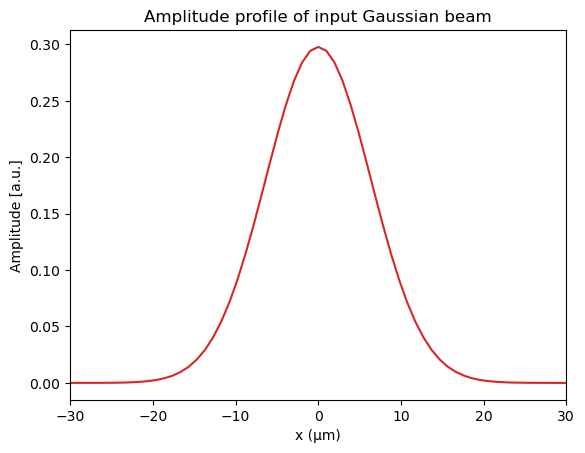

In [6]:
# Generate input Gaussian beam with 9 μm waist centered at x=0
INPUT_MODE = gaussian_beam(X_AXIS, x_center=0, w0=9)

# Plot input beam profile
plt.plot(X_AXIS, INPUT_MODE.abs(), c='tab:red')
plt.xlim(-30, 30)
plt.xlabel('x (μm)')
plt.ylabel('Amplitude [a.u.]')
plt.title('Amplitude profile of input Gaussian beam')

## Simulat and plot results

In [7]:
# Run BPM simulation: vstack creates batch dimension (here 1, but can propagate multiple inputs with shape [batch_size, NX])
# .T transposes dn_prog to (Nz, Nx) format
E_out = bpmsolver.run_simulation(torch.vstack([INPUT_MODE]), dn_prog.T, monitor=True)

Text(0.5, 1.0, 'Intensity distribution of Gaussian beam propagating through Y-splitter')

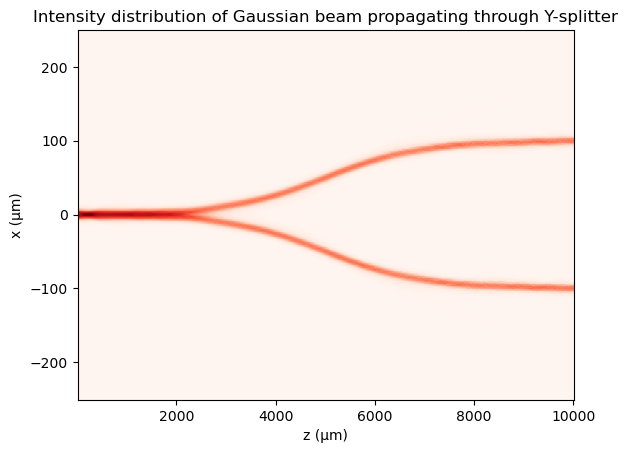

In [ ]:
IND_MODE = 0  # Index of mode to plot (batch dimension)

# Plot intensity distribution: .abs().square() computes |E|², .T transposes to (Nx, Nz) for plotting
plt.pcolormesh(Z_AXIS, X_AXIS, bpmsolver.Emat_x[:, IND_MODE].abs().square().T, cmap='Reds')
plt.xlabel('z (μm)')
plt.ylabel('x (μm)')
plt.title('Intensity distribution of Gaussian beam propagating through Y-splitter')